In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022DL folder and put all the files under A0 folder, then '2022DL/A0'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DPAML'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DPAML' # Please change to your folder
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/DPAML"
print(os.listdir(GOOGLE_DRIVE_PATH))
os.chdir(GOOGLE_DRIVE_PATH)

['create_dataset.py', 'nopre_weights_2021_10_19 14_11_41_history.npy', 'nopre_test_2021_10_19 14_11_41.h5', 'dn2_weights_2021_10_19 13_55_51_history.npy', 'dn1_weights_2021_10_19 13_53_11_history.npy', 'dn2_test_2021_10_19 13_55_51.h5', 'dn1_test_2021_10_19 13_53_11.h5', 'predict.py', 'train.py', 'predo.py', 'nopre_test_2024_03_14 22_55_34.h5', 'nopre_weights_2024_03_14 22_55_34_history.npy', 'create_dataset.ipynb', 'predict.ipynb', 'database', 'denoise_data_image', 'denoise_data_image2', 'result', '__pycache__', 'model_history_save', 'dn2_weights_2024_03_18 18_38_35_history.npy', 'dn2_weights_2024_03_19 16_06_44_history.npy', 'dn2_weights_2024_03_22 03_44_17_history.npy', 'dn2_weights_2024_03_23 03_38_39_history.npy', 'dn2_test_samll.keras', 'dn2_weights_2024_03_23 15_55_13_history.npy', 'train.ipynb']


In [ ]:
import scipy.io
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from PIL import Image
import predo
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,concatenate,Cropping2D
from keras.models import Model
import time
import matplotlib.pyplot as plt
import time

dict_keys(['__header__', '__version__', '__globals__', 'y_onehot', 'x', 'y'])
origin_X shape: (5000,)
origin_Y shape: (5000, 4)
origin_Y_onehot shape: (5000, 4, 19)
origin_X shape: (5000,)
origin_X[0] [[[176 176 176]
  [215 215 215]
  [239 239 239]
  ...
  [ 52  52  52]
  [177 177 177]
  [248 248 248]]

 [[208 208 208]
  [230 230 230]
  [182 182 182]
  ...
  [202 202 202]
  [192 192 192]
  [186 186 186]]

 [[211 211 211]
  [243 243 243]
  [243 243 243]
  ...
  [222 222 222]
  [203 203 203]
  [186 186 186]]

 ...

 [[193 193 193]
  [177 177 177]
  [218 218 218]
  ...
  [195 195 195]
  [235 235 235]
  [216 216 216]]

 [[211 211 211]
  [199 199 199]
  [233 233 233]
  ...
  [212 212 212]
  [213 213 213]
  [212 212 212]]

 [[191 191 191]
  [219 219 219]
  [185 185 185]
  ...
  [204 204 204]
  [175 175 175]
  [240 240 240]]]
origin_X[0] shape: (49, 122, 3)
dict_keys(['__header__', '__version__', '__globals__', 'denoise_x'])
denoise_x shape: (5000, 50, 130)
resize_x shape: (5000, 50, 130)
res

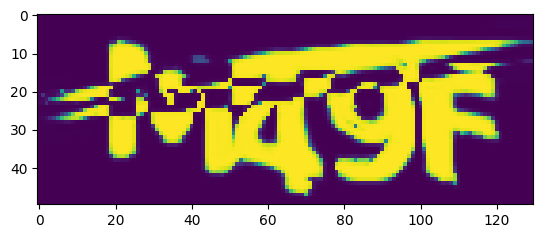

In [ ]:

mode = 'dn2'
origin_X,origin_Y,origin_Y_onehot=predo.load_data()

print ("origin_X shape:",origin_X.shape)
print ("origin_X[0]",origin_X[0])
print ("origin_X[0] shape:",origin_X[0].shape)

if mode == 'nopre': resize_x=predo.resize_img(origin_X,True,False)
elif mode == 'dn1': resize_x=predo.load_data_denoise_train2()
elif mode == 'dn2': resize_x=predo.load_data_denoise_train()

print ("resize_x shape:",resize_x.shape)
print ("resize_x[0] shape:",resize_x[0].shape)

img = Image.fromarray(resize_x[1234])
plt.imshow(img)
plt.show()


**adjust the batch size and number of epochs in the below code block**

In [ ]:

BATCH_SIZE = 256
NUM_EPOCHS = 100 #change to 100

#WEIGHTS_FINAL = 'model-cat-final2.h5'

In [ ]:

train_rate=0.7 #change to 0.9
num_train_data=int(5000*train_rate)

train_x_orig=resize_x.reshape(5000,50,130,-1)[0:num_train_data]
test_x_orig=resize_x.reshape(5000,50,130,-1)[num_train_data:]

x_train=train_x_orig.astype('float32')/255
x_test=test_x_orig.astype('float32')/255

print ("x_train shape: "+str(x_train.shape))
print ("x_test shape: "+str(x_test.shape))

y_train_onehot=origin_Y_onehot[0:num_train_data]
y_test_onehot=origin_Y_onehot[num_train_data:]

print ("y_train_onehot shape: "+str(y_train_onehot.shape))
print ("y_test_onehot shape: "+str(y_test_onehot.shape))

x_train shape: (3500, 50, 130, 1)
x_test shape: (1500, 50, 130, 1)
y_train_onehot shape: (3500, 4, 19)
y_test_onehot shape: (1500, 4, 19)


**adjust your CNN network in the below code block**

In [ ]:

def model(input_shape):
    X_input = Input(input_shape)

#--------------------------------W1--------------------------------------------

    W1 = Conv2D(32, (5, 5), activation = 'relu', padding='same', name = 'conv11_W1')(X_input)
    W1 = Conv2D(32, (5, 5), activation = 'relu', name = 'conv12_W1')(W1)
    W1 = MaxPooling2D((2, 2), name='max_pool1_W1')(W1)

    W1 = Conv2D(64, (3, 3), activation = 'relu', padding='same', name = 'conv23_W1')(W1)
    W1 = Conv2D(64, (3, 3), activation = 'relu', name = 'conv24_W1')(W1)
    # W1 = Conv2D(64, (3, 3), strides = (1, 1), activation = 'relu', name = 'conv25_W1')(W1)

    # W1 = BatchNormalization(axis = 3, name = 'bn1_W1')(W1)
    W1 = MaxPooling2D((2, 2), name='max_pool2_W1')(W1)
    W1 = Dropout(0.5)(W1)

    W1 = Conv2D(128, (3, 3), activation = 'relu', padding='same', name = 'conv36_W1')(W1)
    W1 = Conv2D(128, (3, 3), activation = 'relu', name = 'conv37_W1')(W1)
    # W1 = Conv2D(128, (3, 3), strides = (1, 1), activation = 'relu', name = 'conv38_W1')(W1)
    W1 = MaxPooling2D((2, 2), name='max_pool3_W1')(W1)

    W1 = Conv2D(128, (3, 3), activation = 'relu', padding='same', name = 'conv49_W1')(W1)
    W1 = Conv2D(256, (3, 3), activation = 'relu', name = 'conv410_W1')(W1)
    W1 = BatchNormalization(axis = 3, name = 'bn2_W1')(W1)
    W1 = MaxPooling2D((2, 2), name='max_pool4_W1')(W1)

    W1 = Flatten()(W1)
    W1 = Dropout(0.5)(W1)

    # D1 = Dense(128, activation='relu', name='fc11_W1')(W1)
    # D1 = Dropout(0.25)(D1)
    # D1 = Dense(128, activation='relu', name='fc12_W1')(D1)
    D1 = Dense(19, activation='softmax', name='fc13_W1')(W1)

    # D2 = Dense(128, activation='relu', name='fc11_W2')(W1)
    # D2 = Dropout(0.25)(D2)
    # D2 = Dense(128, activation='relu', name='fc12_W2')(D2)
    D2 = Dense(19, activation='softmax', name='fc13_W2')(W1)

    # D3 = Dense(128, activation='relu', name='fc11_W3')(W1)
    # D3 = Dropout(0.25)(D3)
    # D3 = Dense(128, activation='relu', name='fc12_W3')(D3)
    D3 = Dense(19, activation='softmax', name='fc13_W3')(W1)

    # D4 = Dense(128, activation='relu', name='fc11_W4')(W1)
    # D4 = Dropout(0.25)(D4)
    # D4 = Dense(128, activation='relu', name='fc12_W4')(D4)
    D4 = Dense(19, activation='softmax', name='fc13_W4')(W1)

    model = Model(inputs = X_input, outputs = [D1, D2, D3, D4],name='test')
    return model

In [ ]:
# training
if not os.path.isdir('model_history_save'):
    os.mkdir('model_history_save')

complete_time=time.strftime("%Y_%m_%d %H_%M_%S", time.localtime())
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

# early_stopping : val_loss 連續不降低時，結束訓練
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1,restore_best_weights=True,mode='auto')
# reduce_lr : val_loss 連續不降低時，減少learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                            epsilon=0.0001, cooldown=0, min_lr=0)

checkpoint = ModelCheckpoint("model_history_save/best_model_weights.{epoch:02d}_{val_loss:.2f}.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

if mode == 'nopre': test=model((50,130,3))
else: test=model((50,130,1))

test.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_history=test.fit(x=x_train,y={"fc13_W1":y_train_onehot[:,0,:],"fc13_W2":y_train_onehot[:,1,:],"fc13_W3":y_train_onehot[:,2,:],"fc13_W4":y_train_onehot[:,3,:]},
                        validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,verbose=1, callbacks=[early_stopping,checkpoint,reduce_lr])


Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 11.7742 - fc13_W1_loss: 2.9371 - fc13_W2_loss: 2.9474 - fc13_W3_loss: 2.9448 - fc13_W4_loss: 2.9450 - fc13_W1_accuracy: 0.0657 - fc13_W2_accuracy: 0.0543 - fc13_W3_accuracy: 0.0675 - fc13_W4_accuracy: 0.0600 
Epoch 1: val_loss improved from inf to 11.76338, saving model to model_history_save/best_model_weights.01_11.76.h5
11/11 [==============================] - 146s 13s/step - loss: 11.7742 - fc13_W1_loss: 2.9371 - fc13_W2_loss: 2.9474 - fc13_W3_loss: 2.9448 - fc13_W4_loss: 2.9450 - fc13_W1_accuracy: 0.0657 - fc13_W2_accuracy: 0.0543 - fc13_W3_accuracy: 0.0675 - fc13_W4_accuracy: 0.0600 - val_loss: 11.7634 - val_fc13_W1_loss: 2.9418 - val_fc13_W2_loss: 2.9400 - val_fc13_W3_loss: 2.9401 - val_fc13_W4_loss: 2.9415 - val_fc13_W1_accuracy: 0.0614 - val_fc13_W2_accuracy: 0.0557 - val_fc13_W3_accuracy: 0.0600 - val_fc13_W4_accuracy: 0.0529 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 11.0612 - fc13_W1_loss: 2.7887 - fc13_W2_loss: 2.7729 - fc13_W3_loss: 2.7220 - fc13_W4_loss: 2.7776 - fc13_W1_accuracy: 0.1221 - fc13_W2_accuracy: 0.1257 - fc13_W3_accuracy: 0.1411 - fc13_W4_accuracy: 0.1225 
Epoch 2: val_loss improved from 11.76338 to 11.68227, saving model to model_history_save/best_model_weights.02_11.68.h5
11/11 [==============================] - 143s 13s/step - loss: 11.0612 - fc13_W1_loss: 2.7887 - fc13_W2_loss: 2.7729 - fc13_W3_loss: 2.7220 - fc13_W4_loss: 2.7776 - fc13_W1_accuracy: 0.1221 - fc13_W2_accuracy: 0.1257 - fc13_W3_accuracy: 0.1411 - fc13_W4_accuracy: 0.1225 - val_loss: 11.6823 - val_fc13_W1_loss: 2.9239 - val_fc13_W2_loss: 2.9198 - val_fc13_W3_loss: 2.9157 - val_fc13_W4_loss: 2.9229 - val_fc13_W1_accuracy: 0.0871 - val_fc13_W2_accuracy: 0.0614 - val_fc13_W3_accuracy: 0.0700 - val_fc13_W4_accuracy: 0.0729 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 9.5776 - 

In [ ]:
#info
print(test.summary())
test_weights = np.array(test.get_weights(),dtype=object)

# weight shape
'''
print('weights shape :',test_weights.shape)
for i in range (0,test_weights.shape[0],2):
    print('weights 0 shape :',test_weights[i].shape)
    print('bias 0 shape :',test_weights[i+1].shape)
'''

Model: "test"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 130, 1)]         0         []                            
                                                                                                  
 conv11_W1 (Conv2D)          (None, 50, 130, 32)          832       ['input_3[0][0]']             
                                                                                                  
 conv12_W1 (Conv2D)          (None, 46, 126, 32)          25632     ['conv11_W1[0][0]']           
                                                                                                  
 max_pool1_W1 (MaxPooling2D  (None, 23, 63, 32)           0         ['conv12_W1[0][0]']           
 )                                                                                             

"\nprint('weights shape :',test_weights.shape)\nfor i in range (0,test_weights.shape[0],2):\n    print('weights 0 shape :',test_weights[i].shape)\n    print('bias 0 shape :',test_weights[i+1].shape)\n"

**test.save( )** in the below code block have to adjust if you don't want your saved old model be cover by your new model which is going to be saved.

In [ ]:
#save weights

complete_time=time.strftime("%Y_%m_%d %H_%M_%S", time.localtime())

test.save(mode+'_test_samll'+'.keras')
#test.save_weights(mode+'_weights_'+str(complete_time)+'.h5')

#model.save(WEIGHTS_FINAL)

In [ ]:
#evaluate
scores=test.evaluate(x_test, {"fc13_W1":y_test_onehot[:,0,:],"fc13_W2":y_test_onehot[:,1,:],"fc13_W3":y_test_onehot[:,2,:],"fc13_W4":y_test_onehot[:,3,:]}, verbose=0)
print('Test W1 loss:', scores[1],' Test W1 accuracy:', scores[5])
print('Test W2 loss:', scores[2],' Test W2 accuracy:', scores[6])
print('Test W3 loss:', scores[3],' Test W3 accuracy:', scores[7])
print('Test W4 loss:', scores[4],' Test W4 accuracy:', scores[8])

#儲存history
np.save(mode+'_weights_'+str(complete_time)+'_history.npy',train_history.history)



Test W1 loss: 0.06310684233903885  Test W1 accuracy: 0.9906666874885559
Test W2 loss: 0.05635879561305046  Test W2 accuracy: 0.9900000095367432
Test W3 loss: 0.025181422010064125  Test W3 accuracy: 0.996666669845581
Test W4 loss: 0.016880394890904427  Test W4 accuracy: 0.996666669845581


In [ ]:
#train_history keys
#讀取history
cur_history=np.load(mode+'_weights_'+str(complete_time)+'_history.npy',allow_pickle='TRUE').item()
#cur_history=np.load('nopre_weights_2021_10_19 01_44_22_history.npy',allow_pickle='TRUE').item()
print (cur_history.keys())


dict_keys(['loss', 'fc13_W1_loss', 'fc13_W2_loss', 'fc13_W3_loss', 'fc13_W4_loss', 'fc13_W1_accuracy', 'fc13_W2_accuracy', 'fc13_W3_accuracy', 'fc13_W4_accuracy', 'val_loss', 'val_fc13_W1_loss', 'val_fc13_W2_loss', 'val_fc13_W3_loss', 'val_fc13_W4_loss', 'val_fc13_W1_accuracy', 'val_fc13_W2_accuracy', 'val_fc13_W3_accuracy', 'val_fc13_W4_accuracy', 'lr'])


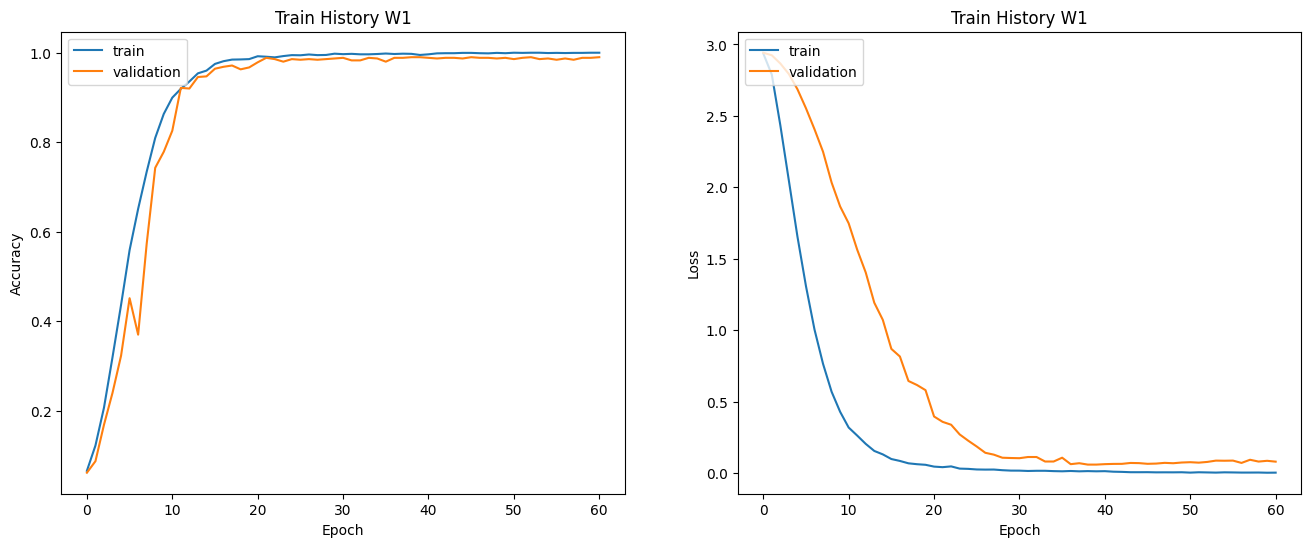

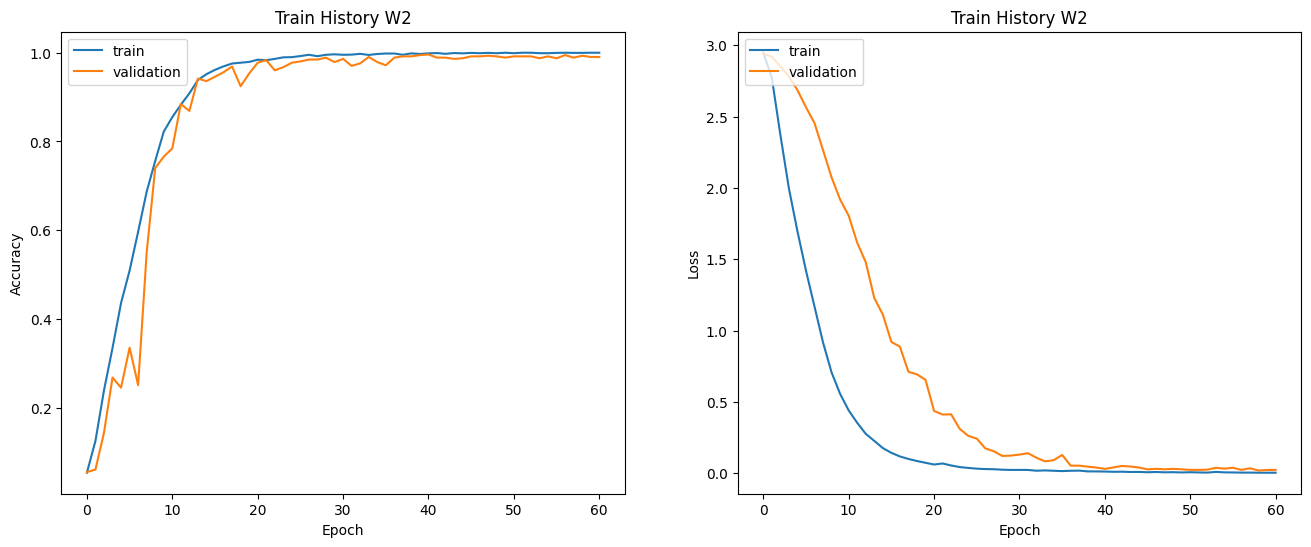

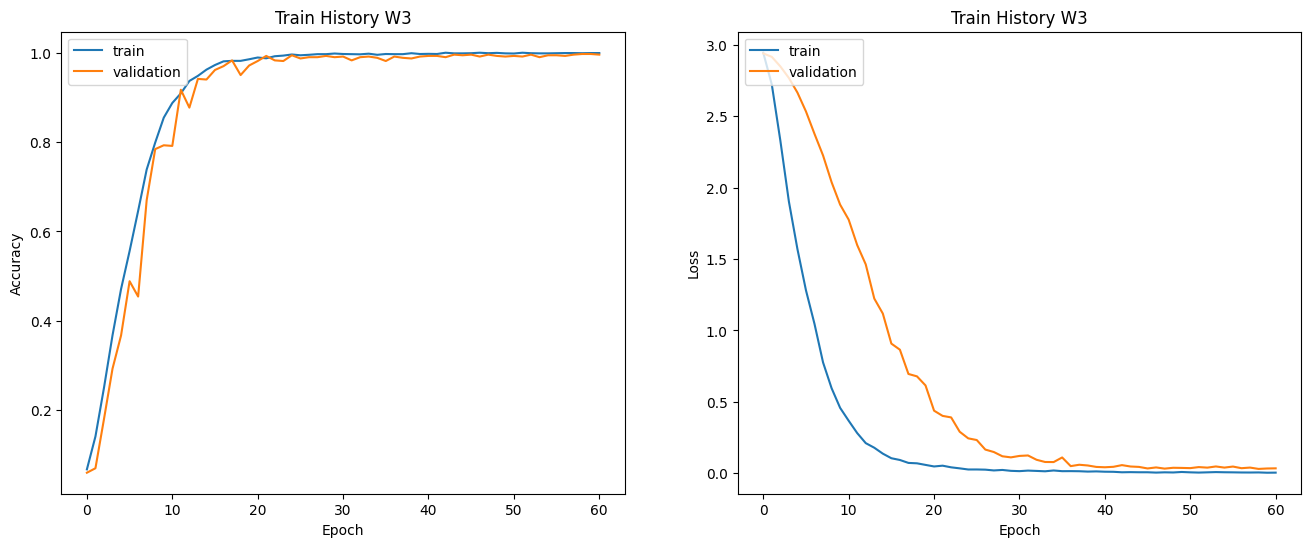

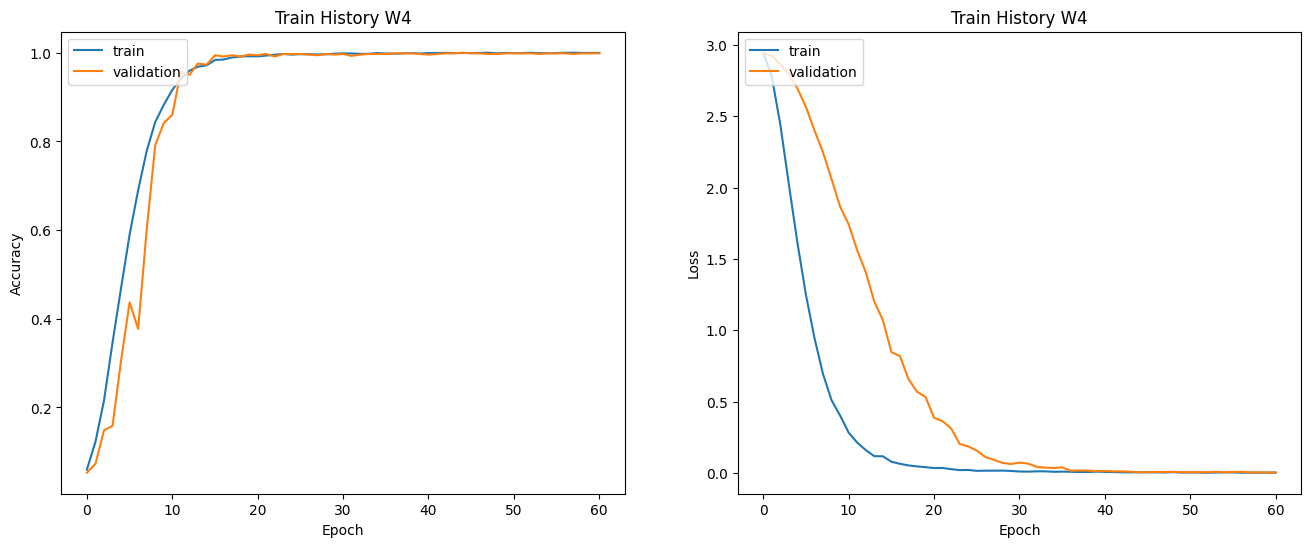

In [ ]:
#plot

def show_train_history(cur_history):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(cur_history["fc13_W1_accuracy"])
    plt.plot(cur_history["val_fc13_W1_accuracy"])
    plt.title("Train History W1")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(cur_history["fc13_W1_loss"])
    plt.plot(cur_history["val_fc13_W1_loss"])
    plt.title("Train History W1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('result/'+mode+"W1.png")
    plt.show()


    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(cur_history["fc13_W2_accuracy"])
    plt.plot(cur_history["val_fc13_W2_accuracy"])
    plt.title("Train History W2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(cur_history["fc13_W2_loss"])
    plt.plot(cur_history["val_fc13_W2_loss"])
    plt.title("Train History W2")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('result/'+mode+"W2.png")
    plt.show()


    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(cur_history["fc13_W3_accuracy"])
    plt.plot(cur_history["val_fc13_W3_accuracy"])
    plt.title("Train History W3")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(cur_history["fc13_W3_loss"])
    plt.plot(cur_history["val_fc13_W3_loss"])
    plt.title("Train History W3")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('result/'+mode+"W3.png")
    plt.show()

    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(cur_history["fc13_W4_accuracy"])
    plt.plot(cur_history["val_fc13_W4_accuracy"])
    plt.title("Train History W4")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(cur_history["fc13_W4_loss"])
    plt.plot(cur_history["val_fc13_W4_loss"])
    plt.title("Train History W4")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('result/'+mode+"W4.png")
    plt.show()



show_train_history(cur_history)

In [ ]:
def one_hot_decode(data):
    data = np.squeeze(data)
    list_max=data.tolist()
    list_max.sort(key=lambda x: float(x), reverse = True)
    n = np.argwhere(data==list_max[0])
    return int(n), list_max[0]

def translate_Y(yi , show = False):

    num = {
        0 : "2", 1 : "3", 2 : "4", 3 : "5", 4 : "7",
        5 : "9", 6 : "A", 7 : "C", 8 : "F", 9 : "H",
        10: "K", 11: "M", 12: "N", 13: "P", 14: "Q",
        15: "R", 16: "T", 17: "Y", 18: "Z"  }

    yi_new = num.get( yi )

    if show:
        print(yi)
        print(yi_new)

    return yi_new

In [ ]:
data = scipy.io.loadmat('database/test.mat')
print("data.keys()",data.keys())

origin_X = np.array(data['x'].flat)
origin_Y = data['y'][0].reshape(3000,-1)
origin_Y_onehot= data['y_onehot'].reshape(3000,4,19)

print ("origin_X shape: "+str(origin_X.shape))
print ("origin_Y shape: "+str(origin_Y.shape))
print ("origin_Y_onehot shape: "+str(origin_Y_onehot.shape))

data.keys() dict_keys(['__header__', '__version__', '__globals__', 'y_onehot', 'x', 'y'])
origin_X shape: (3000,)
origin_Y shape: (3000, 4)
origin_Y_onehot shape: (3000, 4, 19)




-------------------------------------------
---------------- index 0 ----------------
1/1 [==============================] - 0s 255ms/step


<ipython-input-26-1aa7f8f7af57>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(n), list_max[0]


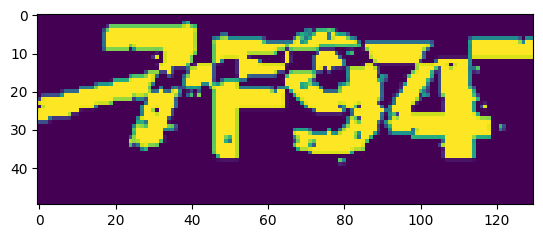

predict= [('7', 'F', '9', '4')]
answer= [('7', 'F', '9', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 1 ----------------
1/1 [==============================] - 0s 37ms/step


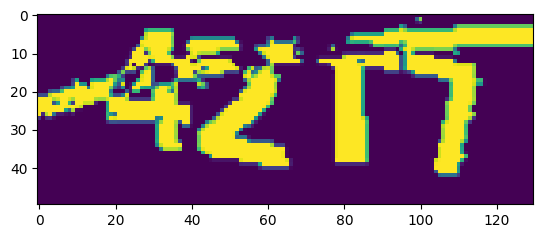

predict= [('4', '2', 'T', '7')]
answer= [('4', '2', 'T', '7')] ,wrong words= 0


-------------------------------------------
---------------- index 2 ----------------
1/1 [==============================] - 0s 37ms/step


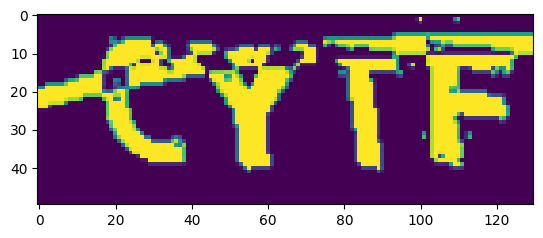

predict= [('C', 'Y', 'T', 'F')]
answer= [('C', 'Y', 'T', 'F')] ,wrong words= 0


-------------------------------------------
---------------- index 3 ----------------
1/1 [==============================] - 0s 35ms/step


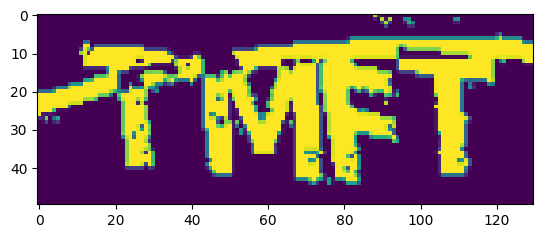

predict= [('T', 'M', 'F', 'T')]
answer= [('T', 'M', 'F', 'T')] ,wrong words= 0


-------------------------------------------
---------------- index 4 ----------------
1/1 [==============================] - 0s 33ms/step


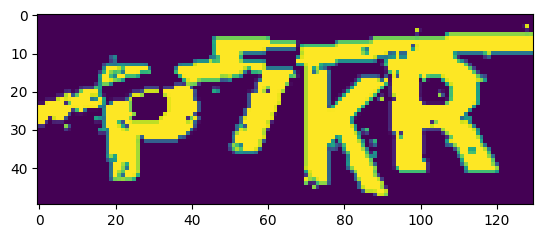

predict= [('P', '7', 'K', 'R')]
answer= [('P', '7', 'K', 'R')] ,wrong words= 0


-------------------------------------------
---------------- index 5 ----------------
1/1 [==============================] - 0s 34ms/step


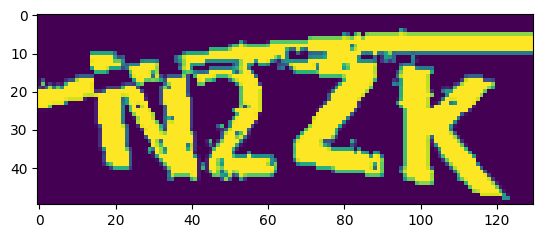

predict= [('N', '2', 'Z', 'K')]
answer= [('N', '2', 'Z', 'K')] ,wrong words= 0


-------------------------------------------
---------------- index 6 ----------------
1/1 [==============================] - 0s 35ms/step


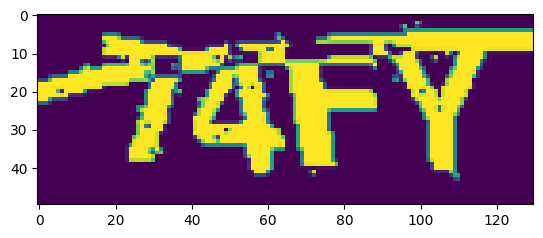

predict= [('7', '4', 'F', 'Y')]
answer= [('7', '4', 'F', 'Y')] ,wrong words= 0


-------------------------------------------
---------------- index 7 ----------------
1/1 [==============================] - 0s 30ms/step


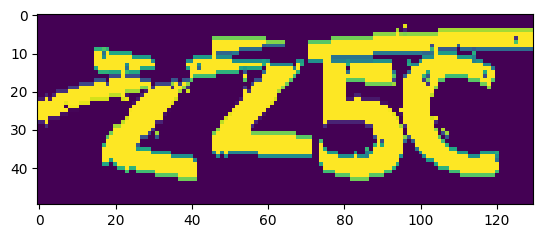

predict= [('Z', 'Z', '5', 'C')]
answer= [('Z', 'Z', '5', 'C')] ,wrong words= 0


-------------------------------------------
---------------- index 8 ----------------
1/1 [==============================] - 0s 35ms/step


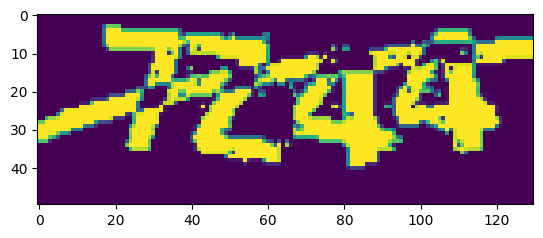

predict= [('7', 'Z', '4', '4')]
answer= [('7', 'Z', '4', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 9 ----------------
1/1 [==============================] - 0s 34ms/step


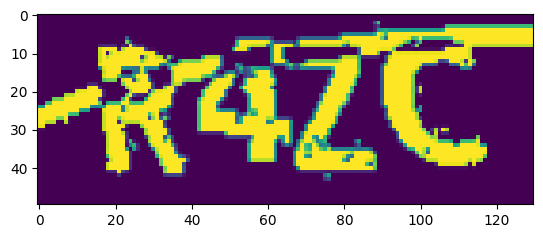

predict= [('R', '4', 'Z', 'C')]
answer= [('R', '4', 'Z', 'C')] ,wrong words= 0


-------------------------------------------
---------------- index 10 ----------------
1/1 [==============================] - 0s 43ms/step


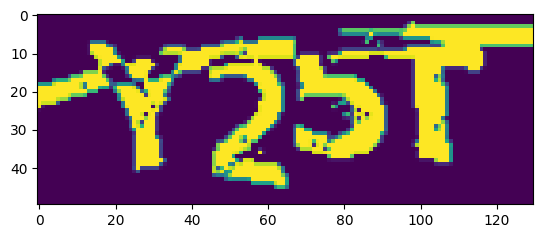

predict= [('Y', '2', '5', 'T')]
answer= [('Y', '2', '5', 'T')] ,wrong words= 0


-------------------------------------------
---------------- index 11 ----------------
1/1 [==============================] - 0s 32ms/step


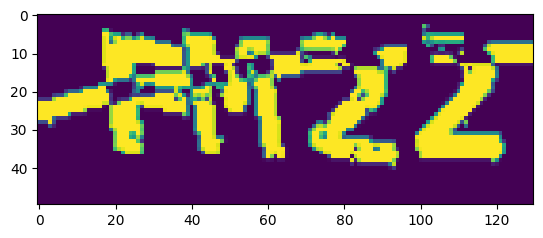

predict= [('F', 'M', '2', '2')]
answer= [('F', 'M', '2', '2')] ,wrong words= 0


-------------------------------------------
---------------- index 12 ----------------
1/1 [==============================] - 0s 32ms/step


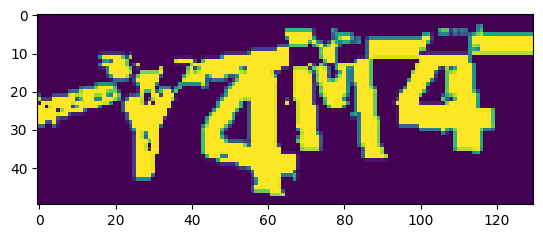

predict= [('Y', '4', 'M', '4')]
answer= [('Y', '4', 'M', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 13 ----------------
1/1 [==============================] - 0s 33ms/step
predict= [('M', '2', '3', '2')]
answer= [('M', '2', 'Q', '2')] ,wrong words= 1


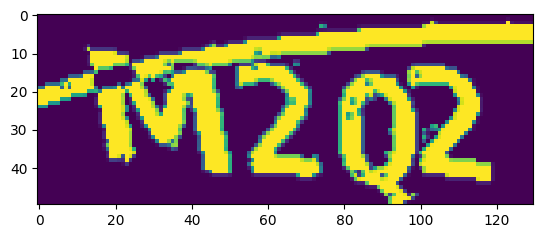

predict= [('M', '2', '3', '2')]
answer= [('M', '2', 'Q', '2')] ,wrong words= 1


-------------------------------------------
---------------- index 14 ----------------
1/1 [==============================] - 0s 31ms/step


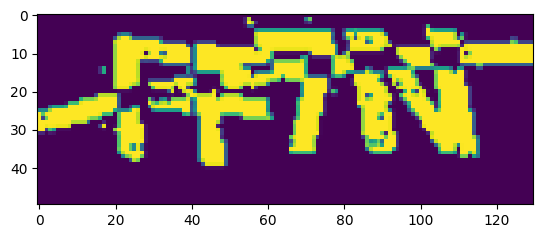

predict= [('F', 'F', '7', 'N')]
answer= [('F', 'F', '7', 'N')] ,wrong words= 0


-------------------------------------------
---------------- index 15 ----------------
1/1 [==============================] - 0s 34ms/step


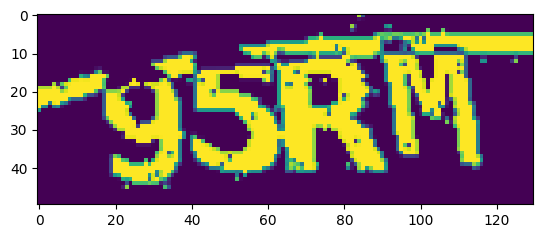

predict= [('9', '5', 'R', 'M')]
answer= [('9', '5', 'R', 'M')] ,wrong words= 0


-------------------------------------------
---------------- index 16 ----------------
1/1 [==============================] - 0s 34ms/step


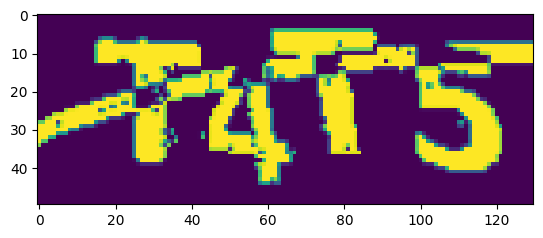

predict= [('T', '4', 'T', '5')]
answer= [('T', '4', 'T', '5')] ,wrong words= 0


-------------------------------------------
---------------- index 17 ----------------
1/1 [==============================] - 0s 31ms/step
predict= [('F', '3', '4', 'A')]
answer= [('F', '3', '4', '3')] ,wrong words= 1


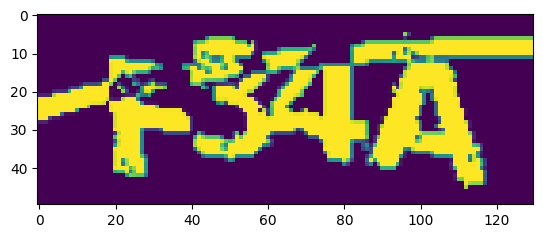

predict= [('F', '3', '4', 'A')]
answer= [('F', '3', '4', '3')] ,wrong words= 1


-------------------------------------------
---------------- index 18 ----------------
1/1 [==============================] - 0s 32ms/step


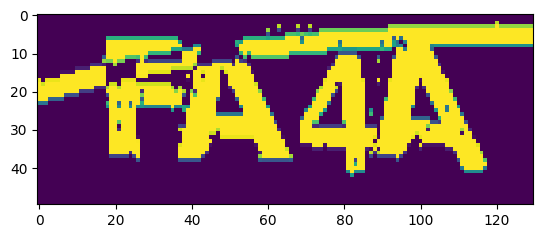

predict= [('F', 'A', '4', 'A')]
answer= [('F', 'A', '4', 'A')] ,wrong words= 0


-------------------------------------------
---------------- index 19 ----------------
1/1 [==============================] - 0s 32ms/step


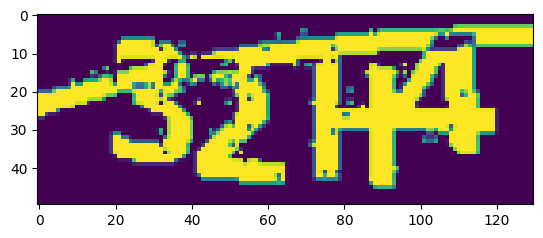

predict= [('3', '2', 'H', '4')]
answer= [('3', '2', 'H', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 20 ----------------
1/1 [==============================] - 0s 31ms/step


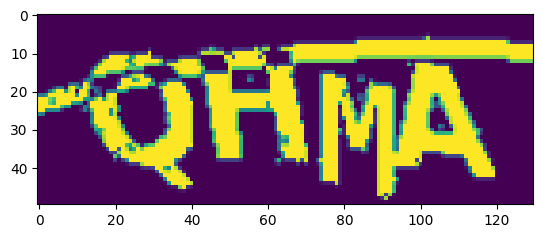

predict= [('Q', 'H', 'M', 'A')]
answer= [('Q', 'H', 'M', 'A')] ,wrong words= 0


-------------------------------------------
---------------- index 21 ----------------
1/1 [==============================] - 0s 31ms/step


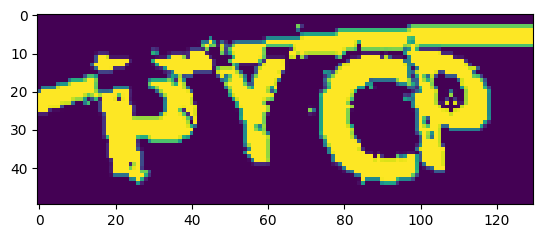

predict= [('P', 'Y', 'C', 'P')]
answer= [('P', 'Y', 'C', 'P')] ,wrong words= 0


-------------------------------------------
---------------- index 22 ----------------
1/1 [==============================] - 0s 31ms/step


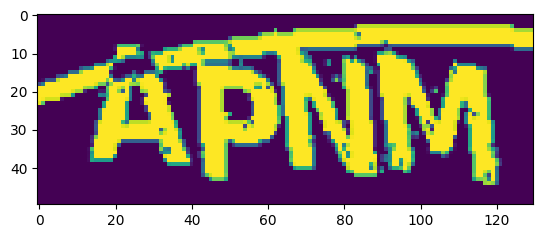

predict= [('A', 'P', 'N', 'M')]
answer= [('A', 'P', 'N', 'M')] ,wrong words= 0


-------------------------------------------
---------------- index 23 ----------------
1/1 [==============================] - 0s 32ms/step


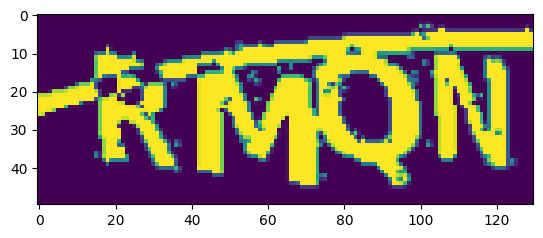

predict= [('R', 'M', 'Q', 'N')]
answer= [('R', 'M', 'Q', 'N')] ,wrong words= 0


-------------------------------------------
---------------- index 24 ----------------
1/1 [==============================] - 0s 31ms/step


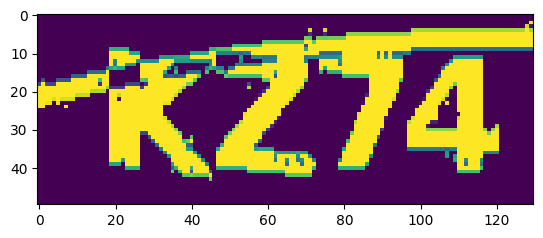

predict= [('K', 'Z', '7', '4')]
answer= [('K', 'Z', '7', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 25 ----------------
1/1 [==============================] - 0s 51ms/step


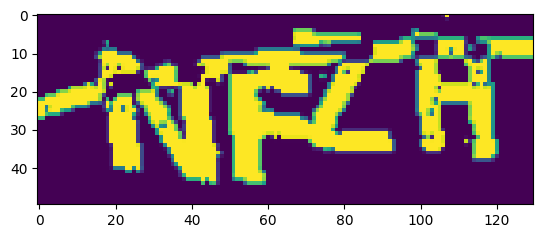

predict= [('N', 'F', 'Z', 'H')]
answer= [('N', 'F', 'Z', 'H')] ,wrong words= 0


-------------------------------------------
---------------- index 26 ----------------
1/1 [==============================] - 0s 65ms/step


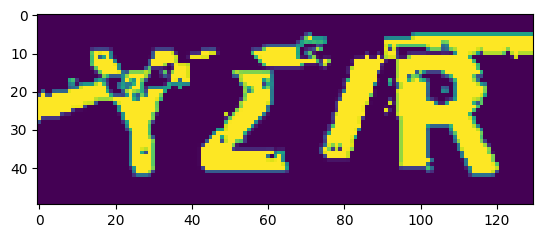

predict= [('Y', '2', '7', 'R')]
answer= [('Y', '2', '7', 'R')] ,wrong words= 0


-------------------------------------------
---------------- index 27 ----------------
1/1 [==============================] - 0s 47ms/step
predict= [('A', 'Y', 'R', 'K')]
answer= [('A', 'Y', 'R', '4')] ,wrong words= 1


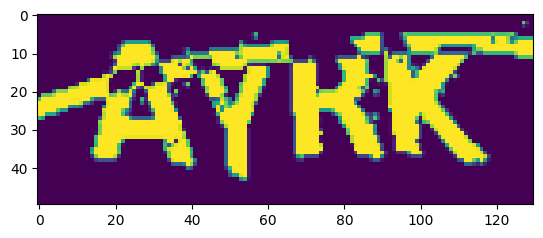

predict= [('A', 'Y', 'R', 'K')]
answer= [('A', 'Y', 'R', '4')] ,wrong words= 1


-------------------------------------------
---------------- index 28 ----------------
1/1 [==============================] - 0s 54ms/step


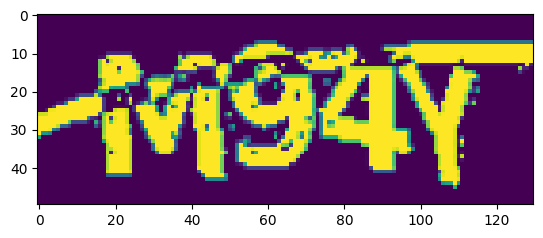

predict= [('M', '9', '4', 'Y')]
answer= [('M', '9', '4', 'Y')] ,wrong words= 0


-------------------------------------------
---------------- index 29 ----------------
1/1 [==============================] - 0s 53ms/step


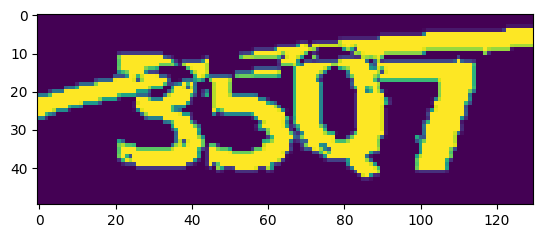

predict= [('3', '5', 'Q', '7')]
answer= [('3', '5', 'Q', '7')] ,wrong words= 0


-------------------------------------------
---------------- index 30 ----------------
1/1 [==============================] - 0s 53ms/step


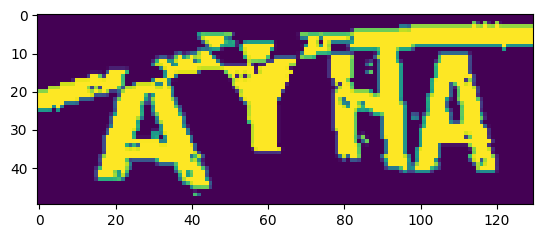

predict= [('A', 'Y', 'H', 'A')]
answer= [('A', 'Y', 'H', 'A')] ,wrong words= 0


-------------------------------------------
---------------- index 31 ----------------
1/1 [==============================] - 0s 56ms/step


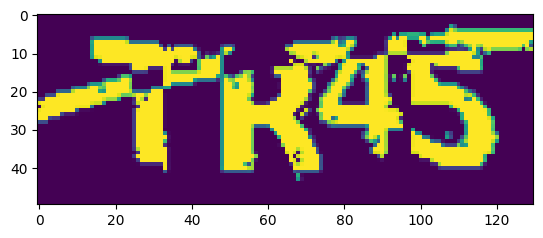

predict= [('T', 'R', '4', '5')]
answer= [('T', 'R', '4', '5')] ,wrong words= 0


-------------------------------------------
---------------- index 32 ----------------
1/1 [==============================] - 0s 55ms/step


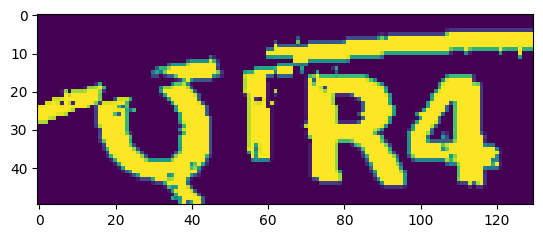

predict= [('Q', 'T', 'R', '4')]
answer= [('Q', 'T', 'R', '4')] ,wrong words= 0


-------------------------------------------
---------------- index 33 ----------------
1/1 [==============================] - 0s 56ms/step


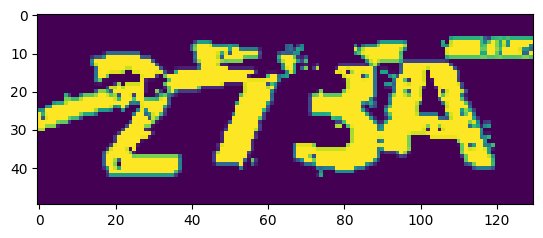

predict= [('2', '7', '3', 'A')]
answer= [('2', '7', '3', 'A')] ,wrong words= 0


-------------------------------------------
---------------- index 34 ----------------
1/1 [==============================] - 0s 33ms/step


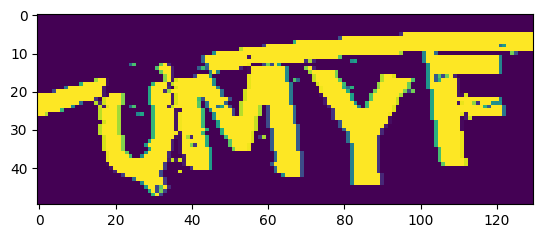

predict= [('Q', 'M', 'Y', 'F')]
answer= [('Q', 'M', 'Y', 'F')] ,wrong words= 0


-------------------------------------------
---------------- index 35 ----------------
1/1 [==============================] - 0s 32ms/step


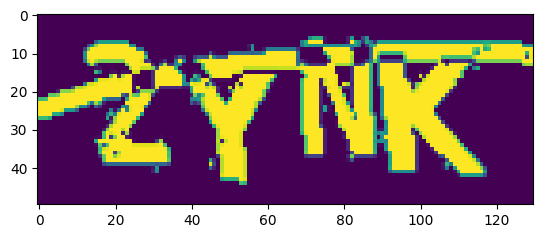

predict= [('2', 'Y', 'N', 'K')]
answer= [('2', 'Y', 'N', 'K')] ,wrong words= 0


-------------------------------------------
---------------- index 36 ----------------
1/1 [==============================] - 0s 42ms/step


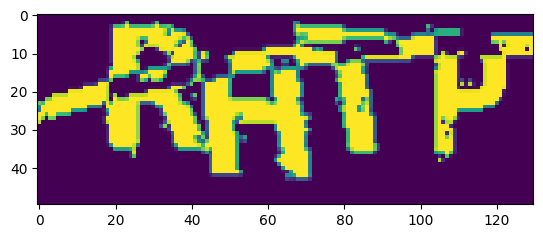

predict= [('R', 'H', 'T', 'P')]
answer= [('R', 'H', 'T', 'P')] ,wrong words= 0


-------------------------------------------
---------------- index 37 ----------------
1/1 [==============================] - 0s 34ms/step
predict= [('7', 'K', 'Q', 'M')]
answer= [('7', 'K', 'Q', '5')] ,wrong words= 1


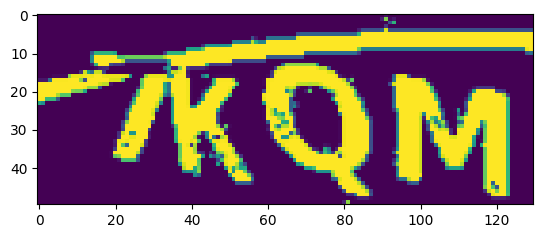

predict= [('7', 'K', 'Q', 'M')]
answer= [('7', 'K', 'Q', '5')] ,wrong words= 1


-------------------------------------------
---------------- index 38 ----------------
1/1 [==============================] - 0s 34ms/step


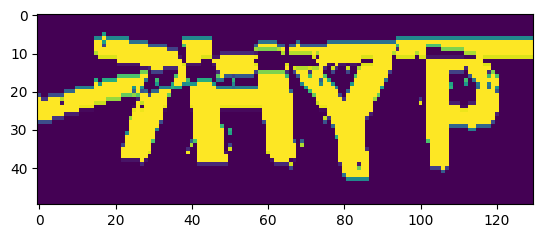

predict= [('7', 'H', 'Y', 'P')]
answer= [('7', 'H', 'Y', 'P')] ,wrong words= 0


-------------------------------------------
---------------- index 39 ----------------
1/1 [==============================] - 0s 45ms/step


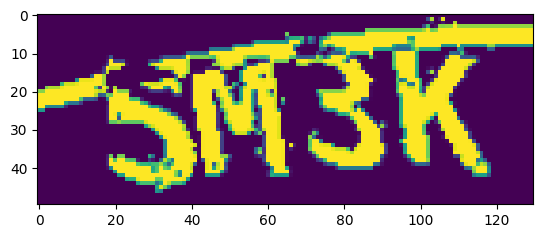

串流輸出內容已截斷至最後 5000 行。
-------------------------------------------
---------------- index 2013 ----------------
1/1 [==============================] - 0s 35ms/step


-------------------------------------------
---------------- index 2014 ----------------
1/1 [==============================] - 0s 33ms/step


-------------------------------------------
---------------- index 2015 ----------------
1/1 [==============================] - 0s 33ms/step


-------------------------------------------
---------------- index 2016 ----------------
1/1 [==============================] - 0s 32ms/step


-------------------------------------------
---------------- index 2017 ----------------
1/1 [==============================] - 0s 33ms/step


-------------------------------------------
---------------- index 2018 ----------------
1/1 [==============================] - 0s 32ms/step


-------------------------------------------
---------------- index 2019 ----------------
1/1 [===========================

In [ ]:
#predict
index=0
error=0
error_n=0
accumulate_time=0

start_total=time.time()

for i in origin_X:
    # 初始化
    print ('\n\n-------------------------------------------')
    print ('---------------- index',index,'----------------')
    predict_out=[]
    answer_out=[]
    temp=0
    start = time.time()
    # 依據使用的模型決定是否要預處理
    # EX: model_name ='dn1_test_2021_10_19 01_47_20.h5'
    #     model_name.split('_')[0] == 'dn1'



    # 以下框起來部分要根據你選擇的資料處理方式做改變
    ############################################################################################
    """
    # if model == 'nopre':
    img = Image.fromarray(i) # array要轉為image才能resize
    img=img.resize((130,50))

    # elif model == 'dn1':
    i=predo.img_denoise(i)
    img = Image.fromarray(i) # array要轉為image才能resize
    img=img.resize((130,50))
    """
    # elif model == 'dn2':
    i=predo.img_denoise2(i)
    img = Image.fromarray(i) # array要轉為image才能resize
    img=img.resize((130,50))
    #############################################################################################



    h=np.array(img)
    #print (h.shape)
    h=h.reshape(1,50,130,-1) # 轉為 (1,50,130,3) or (1,50,130,1)

    prediction=test.predict(h.astype('float32')/255) # predict

    # 轉譯偵測結果
    N1=translate_Y(one_hot_decode(prediction[0])[0]) # one_hot_decode 將19可能依信心排序
    N2=translate_Y(one_hot_decode(prediction[1])[0]) # translate_Y 由數字 1~19轉為符號
    N3=translate_Y(one_hot_decode(prediction[2])[0])
    N4=translate_Y(one_hot_decode(prediction[3])[0])



    predict_out.append((N1,N2,N3,N4)) #四字元合併

    end = time.time()
    accumulate_time += (end - start)

    # 轉譯 Ground Truth
    a1=translate_Y(origin_Y[index][0])
    a2=translate_Y(origin_Y[index][1])
    a3=translate_Y(origin_Y[index][2])
    a4=translate_Y(origin_Y[index][3])

    answer_out.append((a1,a2,a3,a4))


    if N1!=a1:
        error_n+=1 #此模型錯幾個字元
        temp+=1    #此圖錯幾個字元
    if N2!=a2:
        error_n+=1
        temp+=1
    if N3!=a3:
        error_n+=1
        temp+=1
    if N4!=a4:
        error_n+=1
        temp+=1

    if (N1!=a1 or N2!=a2 or N3!=a3 or N4!=a4):
        '''
        img = Image.fromarray(i, 'RGB')
        plt.imshow(img)
        plt.show()
        '''
        error+=1
        print("predict=",predict_out)
        print("answer=",answer_out,",wrong words=",temp)

    if index<40:
        plt.imshow(img)
        plt.show()
        print("predict=",predict_out)
        print("answer=",answer_out,",wrong words=",temp)

    index+=1

In [ ]:
#result
num_picture=index
acc= (num_picture-error)/num_picture
acc_n=(num_picture*4-error_n)/(num_picture*4)

#print (num_picture,"picture total wrong =",error)
print ("image accuracy = ",acc)
print ("word accuracy = ",acc_n)

print ('average per execute time: %f ms' %(accumulate_time/len(origin_X)*1000))

acc_total=0
end_total=time.time()
acc_total+=end_total-start_total
print ("total execute time = %f s " %(acc_total))

image accuracy =  0.967
word accuracy =  0.99025
average per execute time: 162.945478 ms
total execute time = 499.166237 s 
